# Facebook Prophet

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from datetime import timedelta
import warnings

warnings.filterwarnings('ignore')

data = pd.read_csv('AEP_hourly.csv')
data = data.set_index('Datetime')
data = data.sort_index()
data = data[~data.index.duplicated(keep='first')]
data.index = pd.to_datetime(data.index)
data = data.resample('D').sum()[:-1]

train = data[data.index <= '2015-10-27']
test = data[data.index > '2015-10-27']


In [5]:
forecast_1_day = []
forecast_3_day = []
forecast_7_day = []
actual_values = []
dates = []

current_train = train.copy()

for i in range(len(test) - 7):
    train_prophet = current_train.reset_index().rename(columns={'Datetime': 'ds', 'AEP_MW': 'y'})
    model = Prophet()
    model.fit(train_prophet)
    
    end_date = current_train.index[-1]
    future_dates = pd.DataFrame({'ds': [end_date + timedelta(days=d) for d in [1, 3, 7]]})
    
    forecast = model.predict(future_dates)
    
    forecast_1_day.append(forecast['yhat'][0])
    forecast_3_day.append(forecast['yhat'][1])
    forecast_7_day.append(forecast['yhat'][2])
    
    actual_date = end_date + timedelta(days=1)
    actual_value = test.loc[actual_date]['AEP_MW']
    actual_values.append(actual_value)
    dates.append(actual_date)
    
    next_day = test.iloc[[i]]
    current_train = pd.concat([current_train, next_day])

forecast_1_day = pd.Series(forecast_1_day, index=dates)
forecast_3_day = pd.Series(forecast_3_day, index=[d + timedelta(days=2) for d in dates])
forecast_7_day = pd.Series(forecast_7_day, index=[d + timedelta(days=6) for d in dates])
actual_values = pd.Series(actual_values, index=dates)

18:27:07 - cmdstanpy - INFO - Chain [1] start processing
18:27:08 - cmdstanpy - INFO - Chain [1] done processing
18:27:09 - cmdstanpy - INFO - Chain [1] start processing
18:27:10 - cmdstanpy - INFO - Chain [1] done processing
18:27:10 - cmdstanpy - INFO - Chain [1] start processing
18:27:11 - cmdstanpy - INFO - Chain [1] done processing
18:27:11 - cmdstanpy - INFO - Chain [1] start processing
18:27:12 - cmdstanpy - INFO - Chain [1] done processing
18:27:13 - cmdstanpy - INFO - Chain [1] start processing
18:27:13 - cmdstanpy - INFO - Chain [1] done processing
18:27:14 - cmdstanpy - INFO - Chain [1] start processing
18:27:14 - cmdstanpy - INFO - Chain [1] done processing
18:27:15 - cmdstanpy - INFO - Chain [1] start processing
18:27:16 - cmdstanpy - INFO - Chain [1] done processing
18:27:16 - cmdstanpy - INFO - Chain [1] start processing
18:27:17 - cmdstanpy - INFO - Chain [1] done processing
18:27:18 - cmdstanpy - INFO - Chain [1] start processing
18:27:19 - cmdstanpy - INFO - Chain [1]

In [6]:
actual_3_day = test['AEP_MW'].loc[forecast_3_day.index]
actual_7_day = test['AEP_MW'].loc[forecast_7_day.index]

mae_1_day = mean_absolute_error(actual_values, forecast_1_day)
mae_3_day = mean_absolute_error(actual_3_day, forecast_3_day)
mae_7_day = mean_absolute_error(actual_7_day, forecast_7_day)

rmse_1_day = root_mean_squared_error(actual_values, forecast_1_day)
rmse_3_day = root_mean_squared_error(actual_3_day, forecast_3_day)
rmse_7_day = root_mean_squared_error(actual_7_day, forecast_7_day)

print(f"RMSE h = 1: {rmse_1_day:.2f}")
print(f"RMSE h = 3: {rmse_3_day:.2f}")
print(f"RMSE h = 7: {rmse_7_day:.2f}")

print(f"MAE h = 1: {mae_1_day:.2f}")
print(f"MAE h = 3: {mae_3_day:.2f}")
print(f"MAE h = 7: {mae_7_day:.2f}")

RMSE h = 1: 33679.69
RMSE h = 3: 34074.73
RMSE h = 7: 34484.40
MAE h = 1: 25686.60
MAE h = 3: 26002.26
MAE h = 7: 26363.79


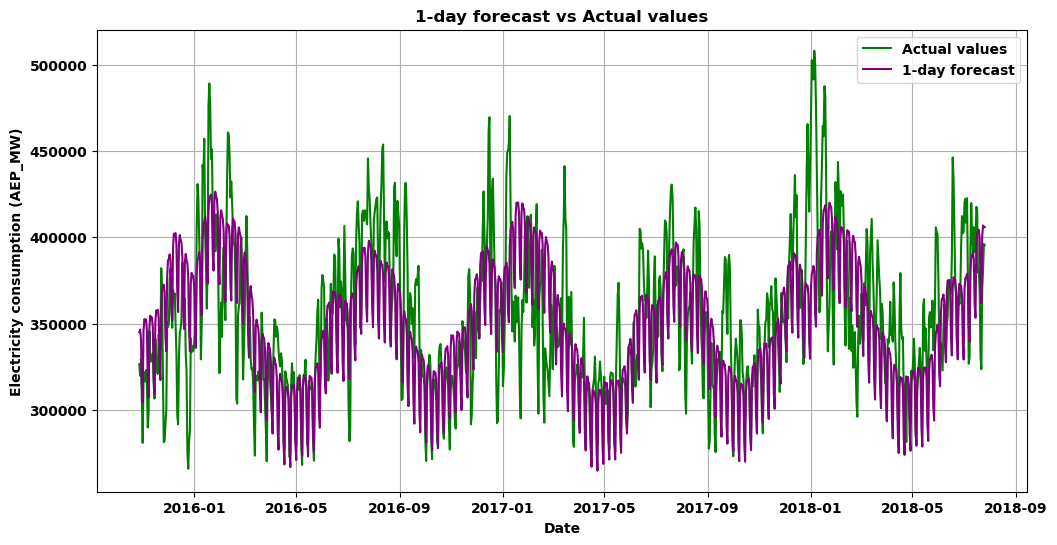

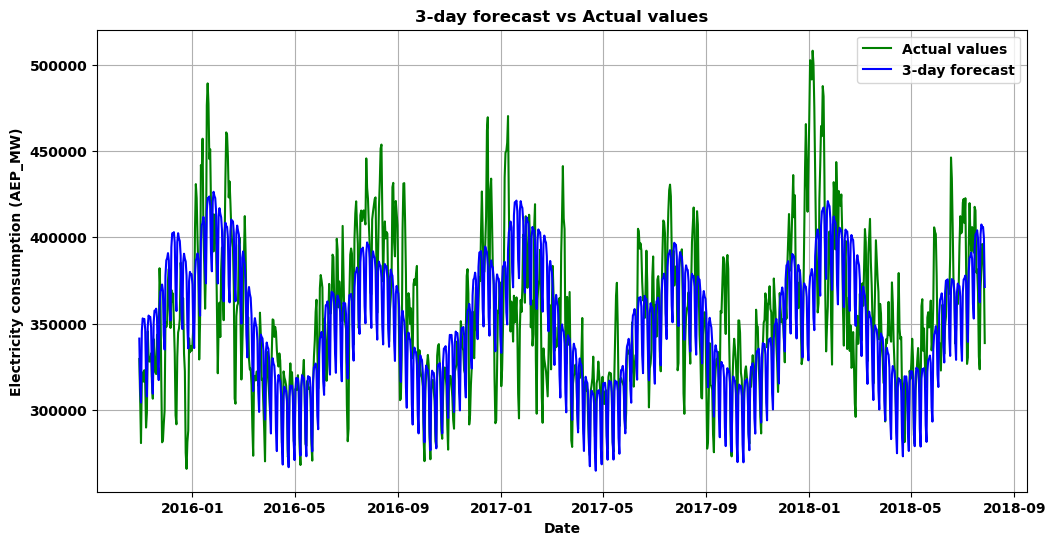

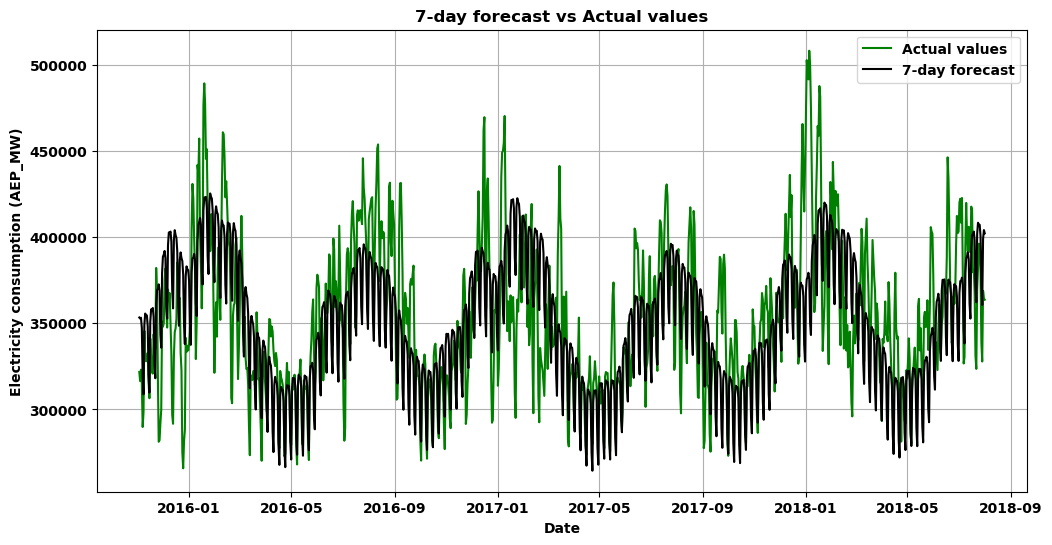

In [7]:
actuals = [actual_values, actual_3_day, actual_7_day]
forecast = [forecast_1_day, forecast_3_day, forecast_7_day]
horizons = [1, 3, 7]
colors = ['purple', 'blue', 'black']
for current_actual, current_forecast, h, color in zip(actuals, forecast, horizons, colors):
    plt.figure(figsize=(12, 6))
    plt.plot(current_actual.index, current_actual, label='Actual values', color='green')
    plt.plot(current_forecast.index, current_forecast, label=f'{h}-day forecast', color=color)
    plt.title(f'{h}-day forecast vs Actual values')
    plt.xlabel('Date')
    plt.ylabel('Electricity consumption (AEP_MW)')
    plt.legend()
    plt.grid()
    plt.show()

In [8]:
pd.DataFrame({'MAE': [mae_1_day, mae_3_day, mae_7_day], 'RMSE': [rmse_1_day, rmse_3_day, rmse_7_day]},
             index=['prophet_h1', 'prophet_h3', 'prophet_h7'])

,MAE,RMSE
prophet_h1,25686.601226,33679.694702
prophet_h3,26002.257657,34074.732951
prophet_h7,26363.794819,34484.402992
